# Image quality
Investigation into image quality with PSNR, SSIM and SNR metrics.

In [1]:
import bids
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from dataframe_help import add_subject_lines, add_temperature_w0_sw, make_global_group_comparison
from stats_help import check_model, bootstrap_validate

sns.set_theme()

In [2]:
# Load data
df_par = pd.read_csv('../data/session_params.csv').drop(columns=['Unnamed: 0'])
df = pd.read_csv('../data/PSNR_df.csv').drop(columns=['index'])

df = add_temperature_w0_sw(df, '../data/')
df = df.drop(df[df['PSNR'] == np.inf].index).reset_index()
df['mod_PSNR'] = 10**(df['PSNR']/10)

Adding in temperature, w0 and SW: 100%|██████████| 242/242 [00:00<00:00, 1912.68it/s]


## Correlation between temperature and w0
Produces figure 6 in the paper.

/Users/emil/miniforge3/envs/rrdf2/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)




------ w0 ~ Temperature ------
MixedLM -> Intercept: 2.74825 (p=0.00e+00)
OLS -> Intercept: 2.69597 (p=1.33e-171)
MixedLM -> Temperature: -0.00154 (p=2.51e-33)
OLS -> Temperature: 0.00084 (p=2.55e-01)
MixedLM -> Group Var: 74.18036 (p=1.52e-02)


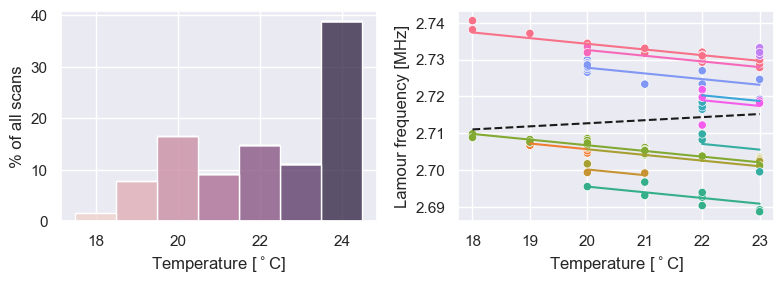

In [3]:
# Paper figure
fig, axes = plt.subplots(1,2, figsize=(8,3))

sns.histplot(df, x='Temperature', hue='Temperature', multiple='stack', discrete=True, stat='percent', legend=False, ax=axes[0])
axes[0].set_ylabel('% of all scans')
axes[0].set_xlabel(r'Temperature [$^\circ$C]')

### w0 ~ Temperature ###
ax = axes[1]
filt_df = df[df.Temperature<24]

xlm_model = smf.mixedlm("w0 ~ Temperature", filt_df, groups=filt_df['Subject'])
xlm_res = xlm_model.fit(method=['lbfgs'])

ols_model = smf.ols("w0 ~ Temperature", filt_df)
ols_res = ols_model.fit()

sns.scatterplot(data=filt_df, x='Temperature', y='w0', hue='Subject', ax=ax)
x = np.linspace(filt_df['Temperature'].min(),filt_df['Temperature'].max())

ax.plot(x, ols_res.params['Intercept'] + x*ols_res.params['Temperature'], '--k')
ax.legend([])
add_subject_lines(ax, df, xlm_res, 'Temperature')

print("\n\n------ w0 ~ Temperature ------")
for k in xlm_res.params.keys():
    print(f"MixedLM -> {k}: {xlm_res.params[k]:.5f} (p={xlm_res.pvalues[k]:.2e})")
    try:
        print(f"OLS -> {k}: {ols_res.params[k]:.5f} (p={ols_res.pvalues[k]:.2e})")
    except:
        continue

ax.set_ylabel('Lamour frequency [MHz]')
ax.set_xlabel(r'Temperature [$^\circ$C]')
ax.legend().remove()

plt.tight_layout()
plt.savefig('../results/figure6_temperature_w0.png', dpi=300)
plt.show()

#### PSNR violin plot and image examples
Produces figure 7 from the paper.

In [4]:
# Used to load local data with the images to display. Not available publicly
projdir = '/Users/emil/Projects/QA/CaliberPaper/lunarc/QA_paper/project'
layout = bids.BIDSLayout(root=projdir+'/rawdata', derivatives=projdir+'/derivatives')

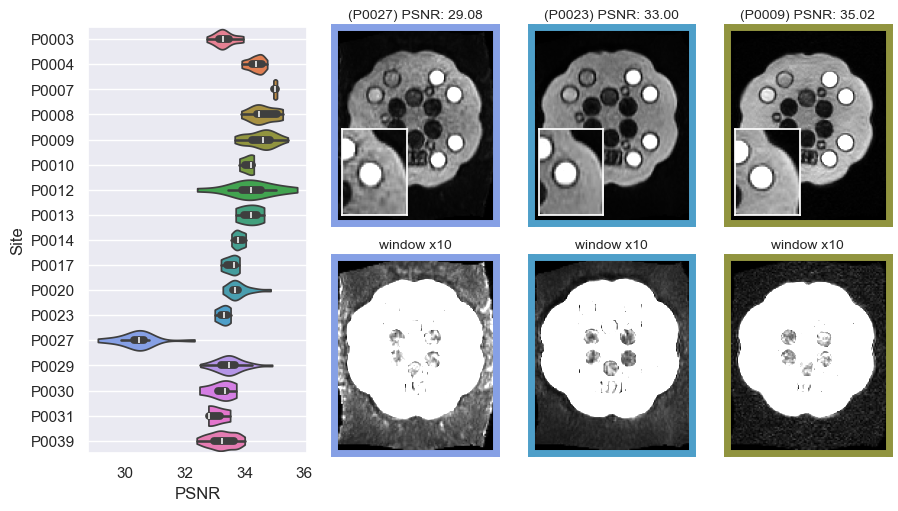

In [5]:
# Example images with different PSNR
my_psnr = [28,30,31,33,34,35]
my_psnr = [28,33,35]
id_psnr = []
for psnr in my_psnr:
    id_psnr.append((df['PSNR']-psnr).abs().idxmin())

sns.set_theme()
fig = plt.figure(constrained_layout=True, figsize=(9,5))
widths = [3.5,3,3,3]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths)
ax = fig.add_subplot(spec[:,0])
violin = sns.violinplot(data=df, y='Subject', x='PSNR', hue='Subject',  alpha=1, orient='h', cut=0)
ax.set_ylabel('Site')
ax.set_xlabel('PSNR')
ax.grid()

violin_colors = {}
for i, artist in enumerate(violin.collections):  # Step by 2 to skip the violin bodies
    facecolor = artist.get_facecolor().tolist()[0]  # Get the RGBA face color
    x_label = ax.get_yticklabels()[i].get_text()  # Get the corresponding x-label
    violin_colors[x_label] = facecolor

for i in range(3):
    row, col = np.unravel_index(i, [2,3])
    ax = fig.add_subplot(spec[row, col+1])
    row = df.loc[id_psnr[i]]
    img = layout.get(scope='raw', extension='.nii.gz', subject=row.Subject, reconstruction='axi', session=row.Session, run=1)[0].get_image().get_fdata()
    img /= np.mean(img)
    ax.imshow(np.rot90(img[:,:,14]), cmap='gray', vmax=6)
    
    zoomed_img = img[70:100, 70:110, 14]
    ax_inset = ax.inset_axes([0.05, 0.01, 0.4, 0.5])
    ax_inset.imshow(np.rot90(zoomed_img), cmap='gray', vmax=6)
    ax_inset.set_xticklabels([]); ax_inset.set_yticklabels([]); ax_inset.grid(None)
    

    ax.set_title(f'({row.Subject}) PSNR: {row.PSNR:.2f}', size=10)
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.grid(None)
    for spine in ax.spines.values():
        spine.set_edgecolor(violin_colors[row.Subject])  # Set the color of the frame
        spine.set_linewidth(5)        # Set the width of the frame

    row, col = np.unravel_index(i+3, [2,3])
    ax = fig.add_subplot(spec[row, col+1])
    row = df.loc[id_psnr[i]]
    ax.imshow(np.rot90(img[:,:,14]), cmap='gray', vmax=0.6)

    ax.set_title(f'window x10', size=10)
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.grid(None)
    for spine in ax.spines.values():
        spine.set_edgecolor(violin_colors[row.Subject])  # Set the color of the frame
        spine.set_linewidth(5)        # Set the width of the frame

plt.savefig('../results/figure7_PSNR_image.png', dpi=300)
plt.show()

In [6]:
# Summary of PSNR
print(f"--- PSNR summary ---")
print(f"Min: {df['PSNR'].min():.3f}\nMax: {df['PSNR'].max():.3f}\nMean: {df['PSNR'].mean():.3f} ")

print(f"--- SSIM summary ---")
print(f"Min: {df['SSIM'].min():.3f}\nMax: {df['SSIM'].max():.3f}\nMean: {df['SSIM'].mean():.3f} ")

--- PSNR summary ---
Min: 29.084
Max: 35.760
Mean: 33.573 
--- SSIM summary ---
Min: 0.955
Max: 0.987
Mean: 0.982 


## Statistics
#### PSNR 

------ PSNR ~ w0 ------
MixedLM -> Intercept: -49098.76104 (p=3.81e-03)
OLS -> Intercept: 39898.28659 (p=4.94e-09)
MixedLM -> w0: 18995.82035 (p=2.41e-03)
OLS -> w0: -13853.39777 (p=3.25e-08)
MixedLM -> Group Var: 6.96613 (p=2.31e-02)


------ PSNR ~ Temperature ------
MixedLM -> Intercept: 5082.78349 (p=2.72e-30)
OLS -> Intercept: 5825.79563 (p=2.81e-23)
MixedLM -> Temperature: -122.45494 (p=7.69e-10)
OLS -> Temperature: -155.64222 (p=4.28e-10)
MixedLM -> Group Var: 3.34163 (p=2.47e-02)


------ w0 ~ Temperature ------
MixedLM -> Intercept: 2.74825 (p=0.00e+00)
OLS -> Intercept: 2.69597 (p=1.33e-171)
MixedLM -> Temperature: -0.00154 (p=2.51e-33)
OLS -> Temperature: 0.00084 (p=2.55e-01)
MixedLM -> Group Var: 74.18036 (p=1.52e-02)


/Users/emil/miniforge3/envs/rrdf2/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


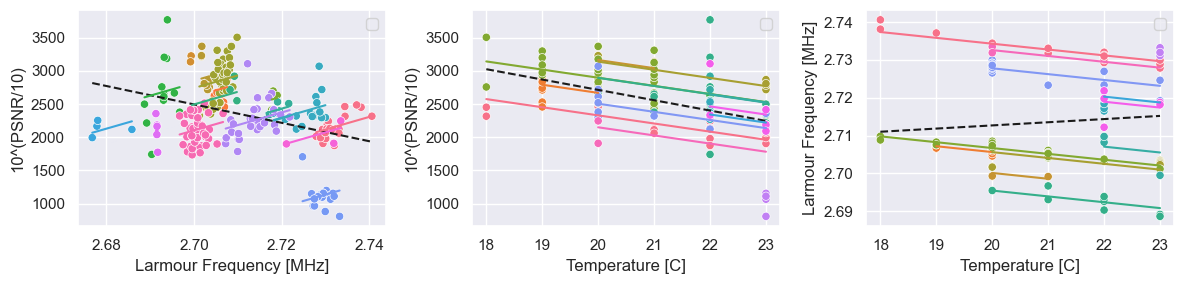

In [7]:
# Ordinary least squares
fig, axes = plt.subplots(1,3, figsize=(12,3))

### PSNR ~ w0 ###
xlm_model = smf.mixedlm("mod_PSNR ~ w0", df, groups=df['Subject'])
xlm_res = xlm_model.fit(method=['lbfgs'])

ols_model = smf.ols("mod_PSNR ~ w0", df)
ols_res = ols_model.fit()

sns.scatterplot(data=df, x='w0', y='mod_PSNR', hue='Subject', ax=axes[0])
x = np.linspace(df['w0'].min(),df['w0'].max())

axes[0].plot(x, ols_res.params['Intercept'] + x*ols_res.params['w0'], '--k')
axes[0].legend([])
add_subject_lines(axes[0], df, xlm_res, 'w0')

print("------ PSNR ~ w0 ------")
for k in xlm_res.params.keys():
    print(f"MixedLM -> {k}: {xlm_res.params[k]:.5f} (p={xlm_res.pvalues[k]:.2e})")
    try:
        print(f"OLS -> {k}: {ols_res.params[k]:.5f} (p={ols_res.pvalues[k]:.2e})")
    except:
        continue

### PSNR ~ Temperature ###
ax = axes[1]
filt_df = df[df.Temperature<24]

xlm_model = smf.mixedlm("mod_PSNR ~ Temperature", filt_df, groups=filt_df['Subject'])
xlm_res = xlm_model.fit(method=['lbfgs'])

ols_model = smf.ols("mod_PSNR ~ Temperature", filt_df)
ols_res = ols_model.fit()

sns.scatterplot(data=filt_df, x='Temperature', y='mod_PSNR', hue='Subject', ax=ax)
x = np.linspace(filt_df['Temperature'].min(),filt_df['Temperature'].max())

ax.plot(x, ols_res.params['Intercept'] + x*ols_res.params['Temperature'], '--k')
ax.legend([])
add_subject_lines(axes[1], df, xlm_res, 'Temperature')

print("\n\n------ PSNR ~ Temperature ------")
for k in xlm_res.params.keys():
    print(f"MixedLM -> {k}: {xlm_res.params[k]:.5f} (p={xlm_res.pvalues[k]:.2e})")
    try:
        print(f"OLS -> {k}: {ols_res.params[k]:.5f} (p={ols_res.pvalues[k]:.2e})")
    except:
        continue

### w0 ~ Temperature ###
ax = axes[2]
filt_df = df[df.Temperature<24]

xlm_model = smf.mixedlm("w0 ~ Temperature", filt_df, groups=filt_df['Subject'])
xlm_res = xlm_model.fit(method=['lbfgs'])

ols_model = smf.ols("w0 ~ Temperature", filt_df)
ols_res = ols_model.fit()

sns.scatterplot(data=filt_df, x='Temperature', y='w0', hue='Subject', ax=ax)
x = np.linspace(filt_df['Temperature'].min(),filt_df['Temperature'].max())

ax.plot(x, ols_res.params['Intercept'] + x*ols_res.params['Temperature'], '--k')
ax.legend([])
add_subject_lines(ax, df, xlm_res, 'Temperature')

print("\n\n------ w0 ~ Temperature ------")
for k in xlm_res.params.keys():
    print(f"MixedLM -> {k}: {xlm_res.params[k]:.5f} (p={xlm_res.pvalues[k]:.2e})")
    try:
        print(f"OLS -> {k}: {ols_res.params[k]:.5f} (p={ols_res.pvalues[k]:.2e})")
    except:
        continue

###########################################################
axes[0].set_xlabel('Larmour Frequency [MHz]')
axes[0].set_ylabel('10^(PSNR/10)')
axes[1].set_xlabel('Temperature [C]')
axes[1].set_ylabel('10^(PSNR/10)')
axes[2].set_xlabel('Temperature [C]')
axes[2].set_ylabel('Larmour Frequency [MHz]')
###########################################################

plt.tight_layout()
plt.show()


#### PSNR and SSIM per site and Software Level
These figures are not included in the paper.

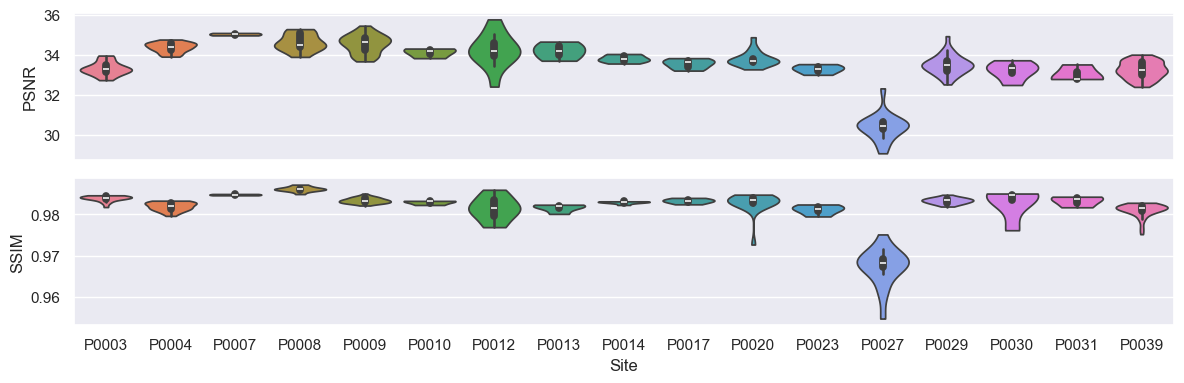

Anova PSNR between site. p=5.60e-17
Anova SSIM between sites. p=3.69e-13


In [8]:
fig, axes = plt.subplots(2,1,figsize=(12,4))
keys = ['PSNR', 'SSIM']
for i in range(2):
    ax = axes[np.unravel_index(i, axes.shape)]
    sns.violinplot(data=df, x='Subject', y=keys[i], hue='Subject',  alpha=1, cut=0, ax=ax)

axes[0].set_xlabel(None)
axes[0].set_xticklabels([])
axes[1].set_xlabel('Site')

plt.tight_layout()
plt.show()

PSNR_anova = sm.stats.anova_oneway(df.PSNR, groups=df.Subject)
print(f"Anova PSNR between site. p={PSNR_anova.pvalue:.2e}")

SSIM_anova = sm.stats.anova_oneway(df.SSIM, groups=df.Subject)
print(f"Anova SSIM between sites. p={SSIM_anova.pvalue:.2e}")

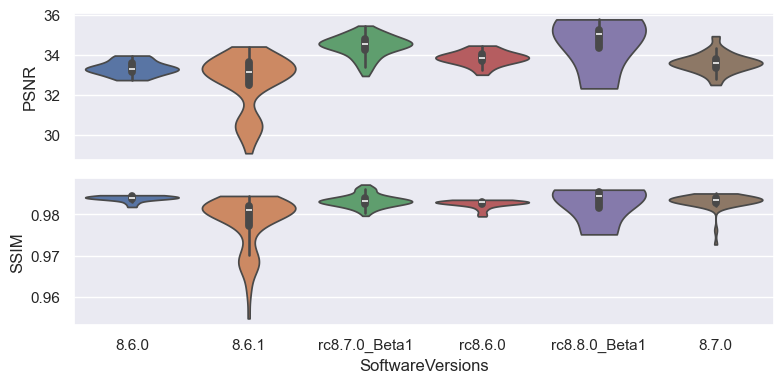

Anova PSNR between SW. p=3.17e-11
Anova SSIM between SW. p=8.19e-07


In [9]:
fig, axes = plt.subplots(2,1,figsize=(8,4))
keys = ['PSNR', 'SSIM']
for i in range(2):
    ax = axes[np.unravel_index(i, axes.shape)]
    sns.violinplot(data=df, x='SoftwareVersions', y=keys[i], hue='SoftwareVersions',  alpha=1, cut=0, ax=ax)

axes[0].set_xlabel(None)
axes[0].set_xticklabels([])

plt.tight_layout()
plt.show()

PSNR_anova = sm.stats.anova_oneway(df.PSNR, groups=df.SoftwareVersions)
print(f"Anova PSNR between SW. p={PSNR_anova.pvalue:.2e}")

SSIM_anova = sm.stats.anova_oneway(df.SSIM, groups=df.SoftwareVersions)
print(f"Anova SSIM between SW. p={SSIM_anova.pvalue:.2e}")

-------------- w0 --------------
OLS params
Intercept: 39898.28659 (p=4.94e-09)
Slope: -13853.39777 (p=3.25e-08)

Mixed params
Intercept: -49098.76104 (p=3.81e-03)
Slope: 18995.82035 (p=2.41e-03)


-------------- Temperature --------------
OLS params
Intercept: 6186.57843 (p=5.77e-52)
Slope: -173.38564 (p=3.63e-27)

Mixed params
Intercept: 4810.71459 (p=1.66e-37)
Slope: -109.84130 (p=2.42e-11)




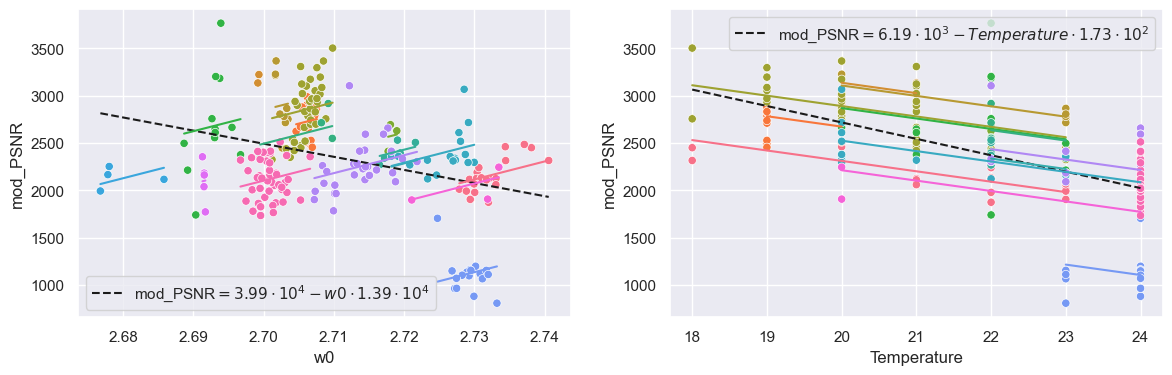

In [10]:
fig, axes = plt.subplots(1,2,figsize=(14,4))
res_lm = {}
res_ol = {}
ax, xlm_res, ols_res = make_global_group_comparison(df, axes[0],'w0', 'mod_PSNR', filter_temp=False)
res_lm['w0'] = xlm_res
res_ol['w0'] = ols_res

ax, xlm_res, ols_res = make_global_group_comparison(df, axes[1],'Temperature', 'mod_PSNR', filter_temp=False)
res_lm['Temperature'] = xlm_res
res_ol['Temperature'] = ols_res

for x in ['w0', 'Temperature']:
    print(f"-------------- {x} --------------")
    print("OLS params")
    print(f"Intercept: {res_ol[x].params['Intercept']:.5f} (p={res_ol[x].pvalues['Intercept']:.2e})")
    print(f"Slope: {res_ol[x].params[x]:.5f} (p={res_ol[x].pvalues[x]:.2e})")

    print("\nMixed params")
    print(f"Intercept: {res_lm[x].params['Intercept']:.5f} (p={res_lm[x].pvalues['Intercept']:.2e})")
    print(f"Slope: {res_lm[x].params[x]:.5f} (p={res_lm[x].pvalues[x]:.2e})")

    print('\n')


For PSNR vs w0 we see that with ordinary least squares we have a negative correlation between w0 and PSNR (black line). However, with a mixed effects model where each group (here site) has a unique intercept, we get a weak positive correlation (colored lines).

There is a clearer overlapping correlation between PSNR and temperature, where both the OLS and mixed effects model shows a negative slope, and both are significant.

/Users/emil/miniforge3/envs/rrdf2/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/emil/miniforge3/envs/rrdf2/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


-------------- w0 --------------
OLS params
Intercept: 1.20466 (p=1.41e-53)
Slope: -0.08228 (p=2.35e-04)

Mixed params
Intercept: 1.06393 (p=2.90e-23)
Slope: -0.03024 (p=4.44e-01)


-------------- Temperature --------------
OLS params
Intercept: 0.99686 (p=2.18e-309)
Slope: -0.00069 (p=9.18e-06)

Mixed params
Intercept: 0.98108 (p=0.00e+00)
Slope: 0.00004 (p=7.63e-01)




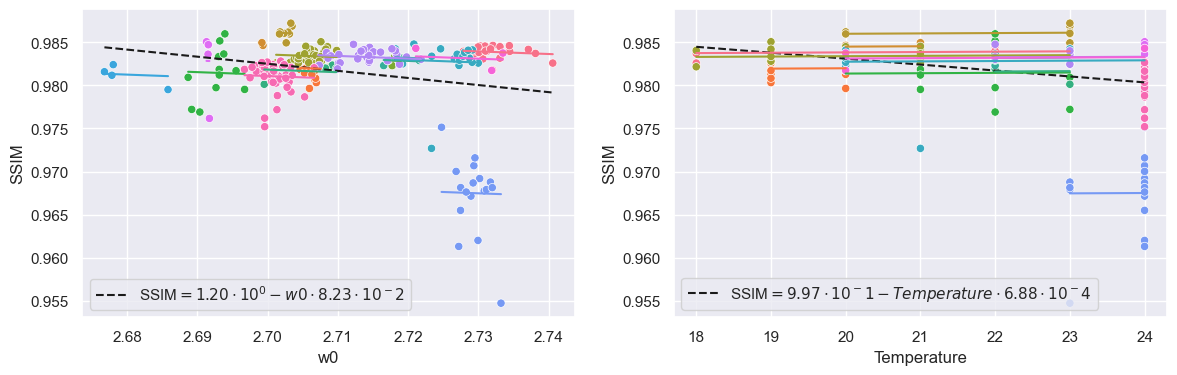

In [11]:
fig, axes = plt.subplots(1,2,figsize=(14,4))
res_lm = {}
res_ol = {}
ax, xlm_res, ols_res = make_global_group_comparison(df, axes[0],'w0', 'SSIM', filter_temp=False)
res_lm['w0'] = xlm_res
res_ol['w0'] = ols_res

ax, xlm_res, ols_res = make_global_group_comparison(df, axes[1],'Temperature', 'SSIM', filter_temp=False)
res_lm['Temperature'] = xlm_res
res_ol['Temperature'] = ols_res

for x in ['w0', 'Temperature']:
    print(f"-------------- {x} --------------")
    print("OLS params")
    print(f"Intercept: {res_ol[x].params['Intercept']:.5f} (p={res_ol[x].pvalues['Intercept']:.2e})")
    print(f"Slope: {res_ol[x].params[x]:.5f} (p={res_ol[x].pvalues[x]:.2e})")

    print("\nMixed params")
    print(f"Intercept: {res_lm[x].params['Intercept']:.5f} (p={res_lm[x].pvalues['Intercept']:.2e})")
    print(f"Slope: {res_lm[x].params[x]:.5f} (p={res_lm[x].pvalues[x]:.2e})")

    print('\n')


When we do the same analysis for SSIM we have a significant negative slope for OLS for both w0 and temperature (black dashed lines). But for the mixed model the slope is non significant.

### Expanded correlation model
To check which factors that PSNR and SSIM are predicted by we run a multiple regression model to see which factors that are significant predictors (through anova analysis). Since we don't know if our variables are normally distributed we run a bootstrap validation of the model as well

------- mod_PSNR -------
                           sum_sq     df          F        PR(>F)
C(SoftwareVersions)  7.462519e+06    5.0  46.739403  2.316278e-27
C(Subject)           1.054233e+07   13.0  25.395747  1.879227e-29
Temperature          1.250538e+06    1.0  39.161972  5.315121e-09
Residual             4.119286e+06  129.0        NaN           NaN
---- Auto correlation ----
Durbin-Watson Test: 2.033 (Close to 2 is good)

---- Check if variance depends on parameter value ----
Lagrange multiplier statistic: 20.1960 (p-value: 0.3829)
f-statistic of the hypothesis that the error variance does not depend on x: 1.1325 (p-value: 0.3288)

----Shapiro-Wilk Test for normality ----
Stat: 0.975 pvalue: 0.007993349805474281


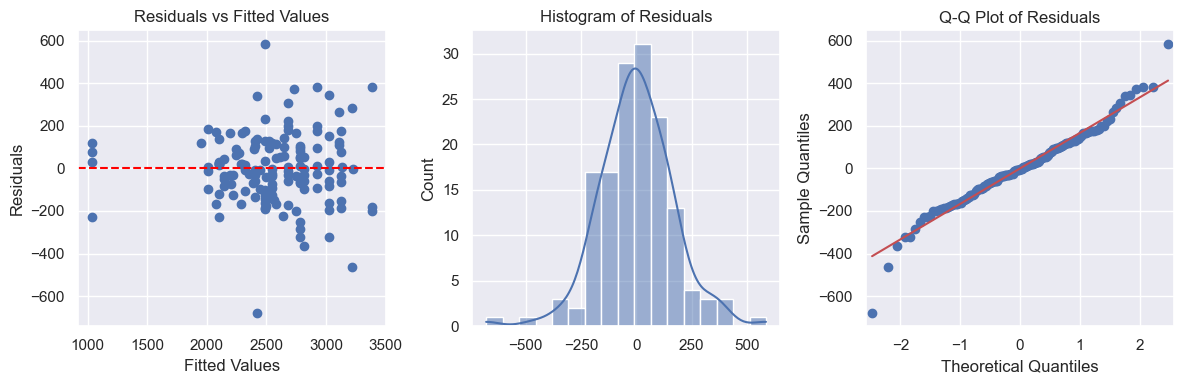

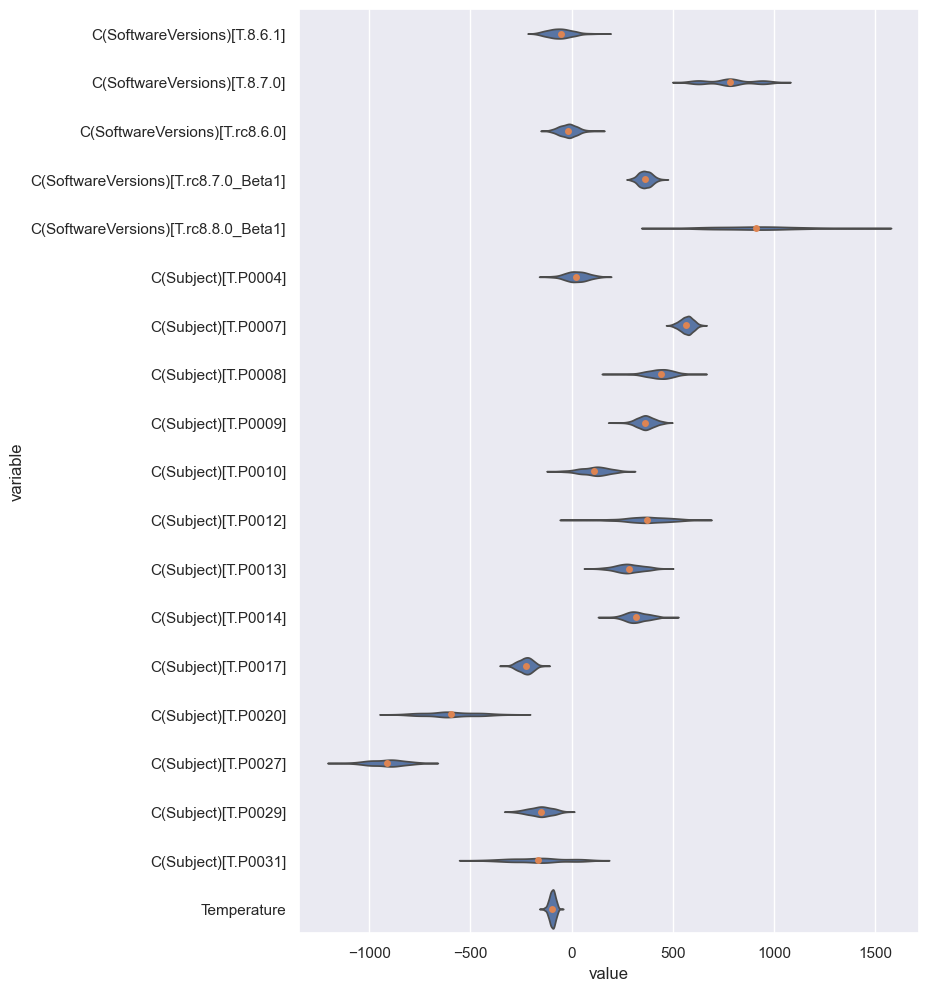

In [12]:
print("------- mod_PSNR -------")
filt_df = df[df.Temperature<24]
formula = 'mod_PSNR ~ Temperature + C(SoftwareVersions) + C(Subject)'
model = smf.ols(formula, data=filt_df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)
check_model(model)
bootstrap_validate(filt_df, model, formula, num_bootstrap=500)


------- SSIM -------
                           sum_sq     df          F        PR(>F)
C(SoftwareVersions)  6.200739e-05    5.0   4.685657  5.781357e-04
C(Subject)           1.030792e-03   13.0  29.958835  9.388323e-33
Temperature          1.041509e-07    1.0   0.039351  8.430664e-01
Residual             3.414229e-04  129.0        NaN           NaN
---- Auto correlation ----
Durbin-Watson Test: 2.112 (Close to 2 is good)

---- Check if variance depends on parameter value ----
Lagrange multiplier statistic: 36.4236 (p-value: 0.0094)
f-statistic of the hypothesis that the error variance does not depend on x: 2.3395 (p-value: 0.0032)

----Shapiro-Wilk Test for normality ----
Stat: 0.663 pvalue: 5.736907167894583e-17


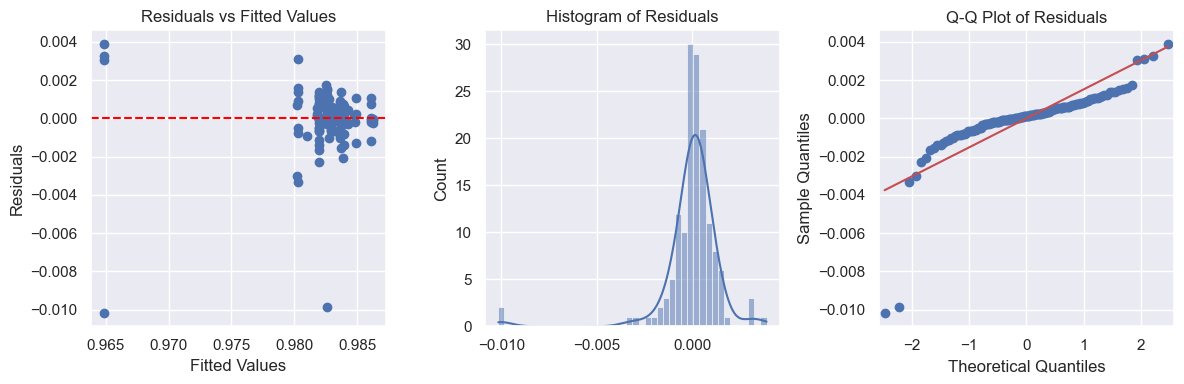

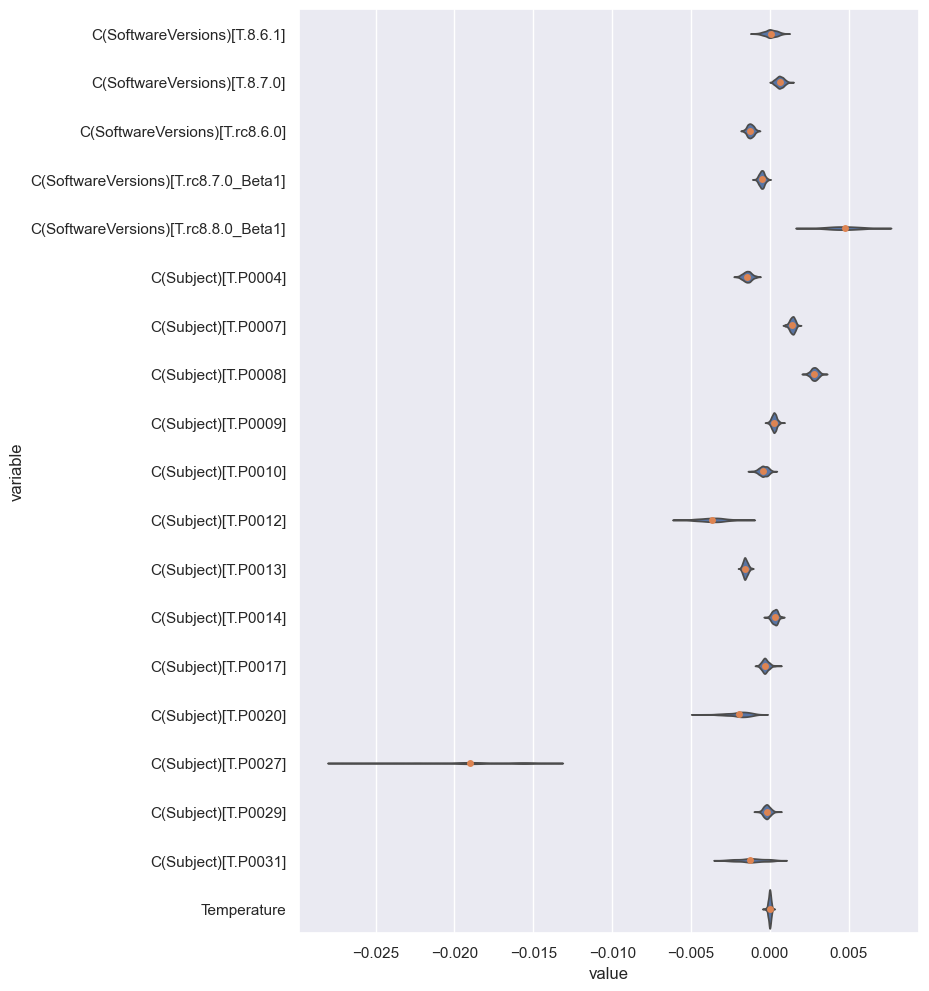

In [13]:
print("\n------- SSIM -------")
formula = 'SSIM ~ Temperature + C(SoftwareVersions) + C(Subject)'
model = smf.ols(formula, data=filt_df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)
check_model(model)
bootstrap_validate(filt_df, model, formula, num_bootstrap=500)

Conclusion: For PSNR, all variables were significant predictors. For SSIM all but temperature were significant. Neither PSNR or SSIM are perfectly distributed but the the bootstrap analysis of the paramter estimates (bottom large plots) shows that the estimated values lies pretty much in the middle of the estimates from the bootstrap analysis as well, which makes it a valid assumption.

## Simulation of how PSNR and SSIM relates to classic SNR measurements

In [26]:
import ants
from tqdm import tqdm 

from ghost.phantom import Caliber137
from ghost.utils import calc_psnr, calc_ssim, calc_snr_diff

In [20]:
def add_rician_noise(data, sd, rng):
    noise = rng.normal(0, sd, [*data.shape, 2])
    return np.sqrt( abs(data + noise[...,0])**2 + abs(1j*noise[...,1])**2)

In [21]:
phantom = Caliber137()

fname = phantom.get_phantom_nii(weighting='T2w')
data = ants.image_read(fname)

fname = phantom.get_seg_nii('phantomMask')
seg = ants.image_read(fname)

fname = phantom.get_seg_nii('BG')
BG = ants.image_read(fname)

In [22]:
# Downsample and scale data
data_rs = ants.resample_image(data, [1.5, 1.5, 5], interp_type=0, use_voxels=False).numpy()
data_rs /= np.max(data_rs)

seg_rs = ants.resample_image(seg, [1.5, 1.5, 5], interp_type=1, use_voxels=False).numpy()
seg_rs[seg_rs==0] = np.nan

BG_rs = ants.resample_image(BG, [1.5, 1.5, 5], interp_type=1, use_voxels=False).numpy()
BG_rs[BG_rs==0] = np.nan

# Crop images to save time
data_rs = data_rs[25:-25, 25:-25, 1:-4]
seg_rs = seg_rs[25:-25, 25:-25, 1:-4]
BG_rs = BG_rs[25:-25, 25:-25, 1:-4]

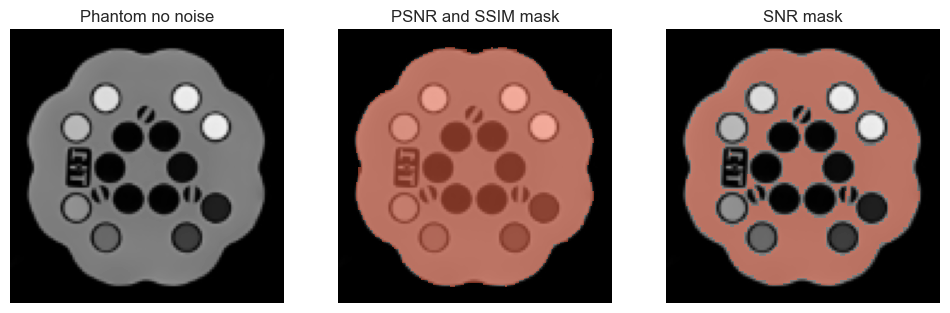

In [23]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

axes[0].imshow(data_rs[:,:,20], cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Phantom no noise')

axes[1].imshow(data_rs[:,:,20], cmap='gray', vmin=0, vmax=1)
axes[1].imshow(seg_rs[:,:,20], cmap='Reds', vmin=0, vmax=2, alpha=0.5)
axes[1].set_title('PSNR and SSIM mask')

axes[2].imshow(data_rs[:,:,20], cmap='gray', vmin=0, vmax=1)
axes[2].imshow(BG_rs[:,:,20], cmap='Reds', vmin=0, vmax=2, alpha=0.5)
axes[2].set_title('SNR mask')

for ax in axes:
    ax.axis('off')

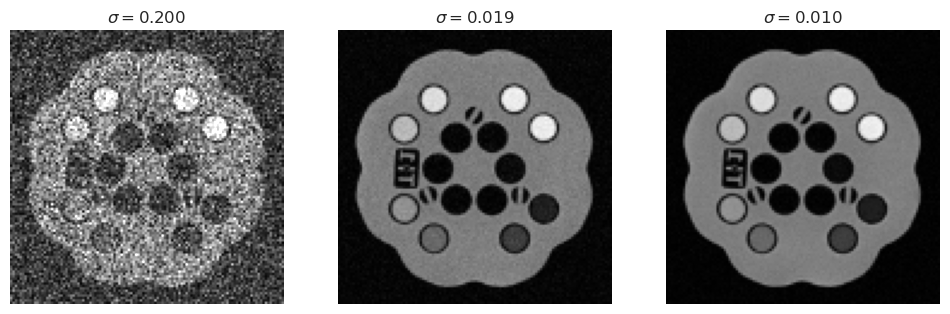

In [24]:
rng = np.random.default_rng(seed=42)
n_noise = 50
noise_levels = np.linspace(5,100, num=n_noise)
ns = noise_levels[[0,n_noise//2, n_noise-1]]

fig, axes = plt.subplots(1,3,figsize=(12,4))
for i in range(len(ns)):
    img1 = add_rician_noise(data_rs, 1/ns[i], rng)
    axes[i].imshow(img1[:,:,20], vmin=0, vmax=1, cmap='gray')
    axes[i].set_title(fr'$\sigma={1/ns[i]:.3f}$')
    axes[i].axis('off')


In [27]:
n_iter = 100

mat_psnr = np.zeros([n_iter, len(noise_levels)])
mat_psnr_ref = np.zeros_like(mat_psnr)
mat_ssim = np.zeros_like(mat_psnr)
mat_ssim_ref = np.zeros_like(mat_psnr)
mat_snr = np.zeros_like(mat_psnr)

for i,s in tqdm(enumerate(noise_levels)):
    for k in range(n_iter):
        img1 = add_rician_noise(data_rs, 1/s, rng)
        img2 = add_rician_noise(data_rs, 1/s, rng)

        MSE, PSNR = calc_psnr(img1, img2, seg_rs)
        _, PSNR_ref = calc_psnr(data_rs, img2, seg_rs)

        SNR = calc_snr_diff(img1, img2, BG_rs)
        mSSIM = calc_ssim(img1, img2, seg_rs)
        mSSIM_ref = calc_ssim(data_rs, img2, seg_rs)

        mat_ssim[k,i] = mSSIM
        mat_ssim_ref[k,i] = mSSIM_ref
        mat_psnr[k,i] = PSNR
        mat_psnr_ref[k,i] = PSNR_ref
        mat_snr[k,i] = SNR
        

50it [06:14,  7.50s/it]


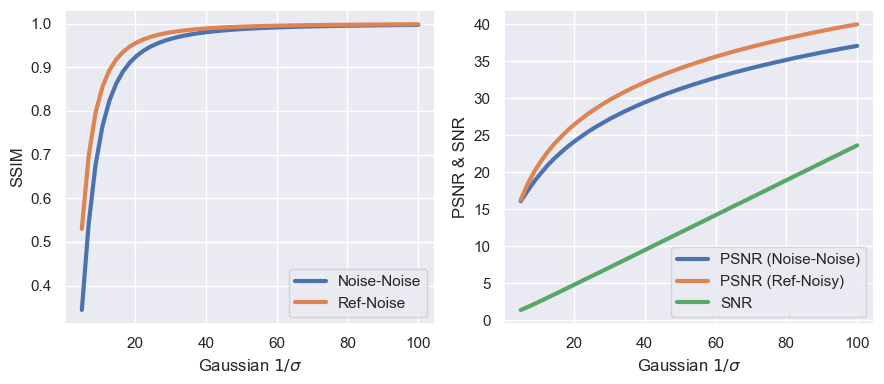

In [28]:
sns.set_theme()

fig, axes = plt.subplots(1,2,figsize=(9,4))
ax = axes[0]
ax.plot(noise_levels, np.mean(mat_ssim, axis=0), linewidth=3, label='Noise-Noise')
ax.plot(noise_levels, np.mean(mat_ssim_ref, axis=0), linewidth=3, label='Ref-Noise')
ax.set_ylabel("SSIM")

ax = axes[1]
ax.plot(noise_levels, np.mean(mat_psnr, axis=0), linewidth=3, label='PSNR (Noise-Noise)')
ax.plot(noise_levels, np.mean(mat_psnr_ref, axis=0), linewidth=3, label='PSNR (Ref-Noisy)')
ax.plot(noise_levels, np.mean(mat_snr, axis=0), linewidth=3, label='SNR')

ax.set_ylabel('PSNR & SNR')

for ax in axes:
    ax.set_xlabel(r'Gaussian $1/\sigma$')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../results/figureS4_SNR_simulation.png', dpi=300)
plt.show()